In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, \
                            roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_profile[['CustomerID', 'Delta','Median', 'RFrequency']].merge(customer_clustering[['CustomerID', 'Label']], on='CustomerID')
del customer_profile
customer_clustering

,CustomerID,Delta,Median,RFrequency,Label
0,12347,366,584.910,0.019126,High
1,12348,283,298.500,0.014134,Medium
2,12350,1,294.400,1.000000,Low
3,12352,261,226.250,0.026820,Medium
4,12353,1,89.000,1.000000,Low
...,...,...,...,...,...
3855,18280,1,180.600,1.000000,Low
3856,18281,1,80.820,1.000000,Low
3857,18282,119,89.025,0.016807,Medium
3858,18283,334,113.500,0.047904,Medium


In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
# Oversample minority classes.

df_minority_oversampled = resample(df_minority,
                                   replace=True,  # Sample with replacement.
                                   n_samples=len(df_majority))

df_middle_oversampled = resample(df_middle,
                                 replace=True,
                                 n_samples=len(df_majority))

# Combine majority class with oversampled minority classes.
df_oversampled = pd.concat([df_majority, df_minority_oversampled, df_middle_oversampled])
 
# Display new class counts.
customer_clustering = df_oversampled
customer_clustering.Label.value_counts()

High      1698
Medium    1698
Low       1698
Name: Label, dtype: int64

In [5]:
'''
# Undersampling.

df_majority_undersampled = resample(df_majority,
                                    replace=False,  # Sample without replacement.
                                    n_samples=len(df_minority))

df_middle_undersampled = resample(df_middle,
                                  replace=False,
                                  n_samples=len(df_minority))

df_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])

customer_clustering = df_undersampled
customer_clustering.Label.value_counts()
'''

'\n# Undersampling.\n\ndf_majority_undersampled = resample(df_majority,\n                                    replace=False,  # Sample without replacement.\n                                    n_samples=len(df_minority))\n\ndf_middle_undersampled = resample(df_middle,\n                                  replace=False,\n                                  n_samples=len(df_minority))\n\ndf_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])\n\ncustomer_clustering = df_undersampled\ncustomer_clustering.Label.value_counts()\n'

In [6]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [7]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta', 'Median', 'Label_num']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

## Expected prediction

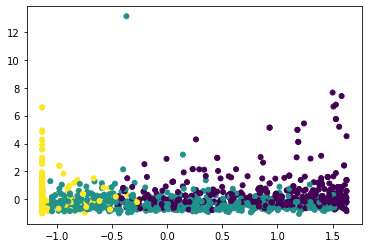

In [8]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)
plt.show()

## Decision Tree

In [9]:
# Decision tree

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12],
              "min_samples_split": sp_randint(20, 30),
              "min_samples_leaf": sp_randint(5, 30),
              "criterion": ["entropy", "gini"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()

grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist,
                                 n_iter=n_iter_search,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [10]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 19, 'min_samples_split': 28}


In [11]:
# Decision tree best setting parameters

dec_t = tree.DecisionTreeClassifier(**grid_search.best_params_).fit(train_set, train_label)

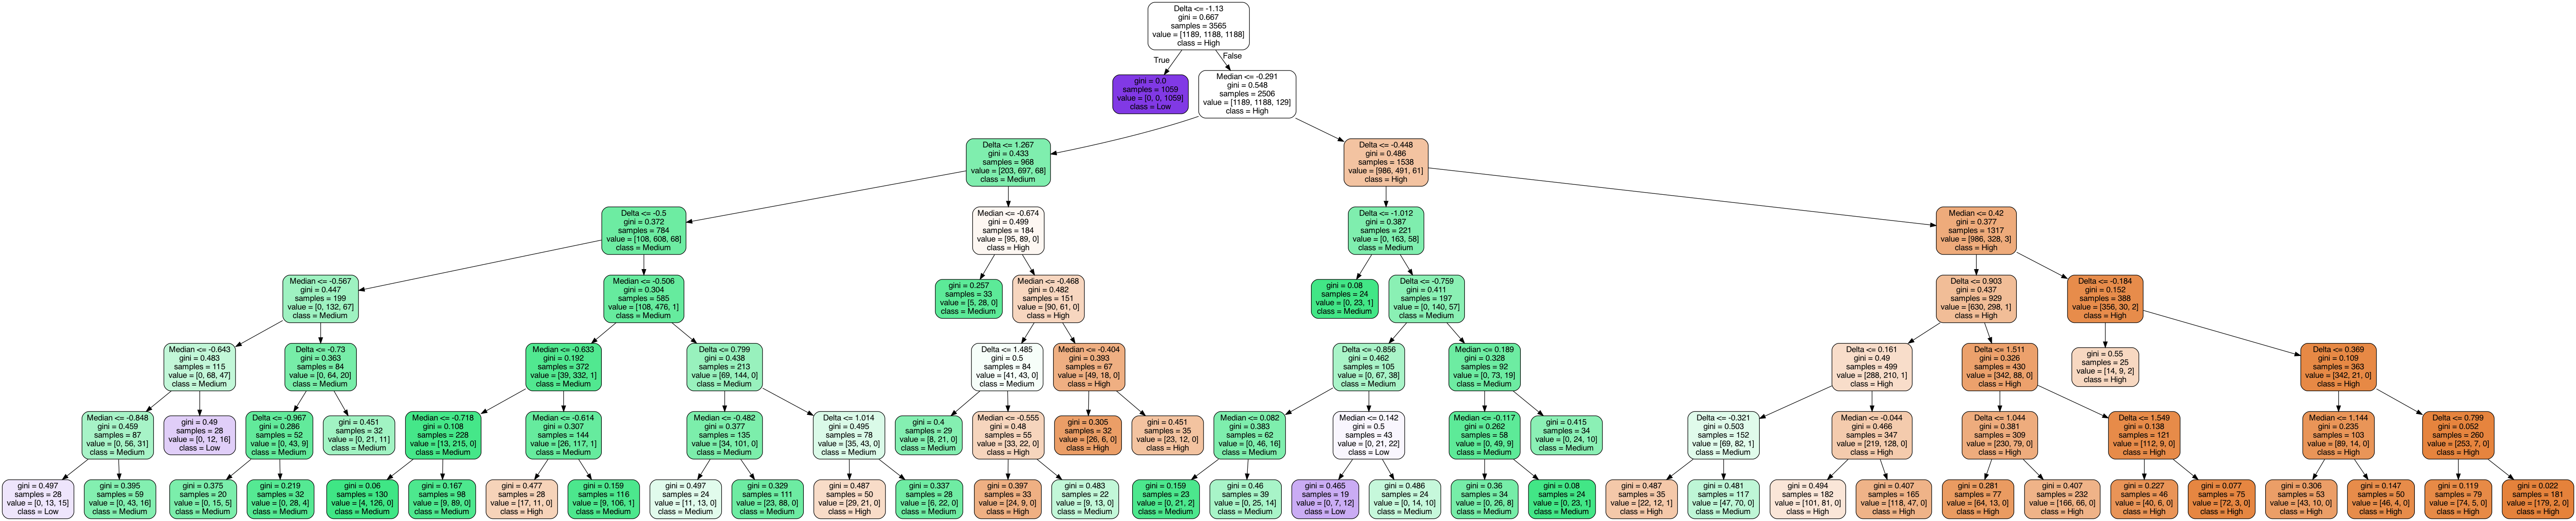

In [12]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Delta', 'Median'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [13]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [14]:
# Predict phase

train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [15]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [16]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.841234221598878
Accuracy test set:  0.8103335513407456

F1 score train set: 0.8407497670232718
F1 score test set:  0.8098947657449969
Train:
              precision    recall  f1-score   support

        High       0.77      0.89      0.82      1189
      Medium       0.80      0.71      0.75      1188
         Low       0.97      0.93      0.95      1188

    accuracy                           0.84      3565
   macro avg       0.85      0.84      0.84      3565
weighted avg       0.85      0.84      0.84      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.75      0.85      0.80       509
      Medium       0.74      0.67      0.70       510
         Low       0.95      0.91      0.93       510

    accuracy                           0.81      1529
   macro avg       0.81      0.81      0.81      1529
weighted avg       0.81      0.81      0.81      1529



In [17]:
# Compute confusion matrix.

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1058  131    0]
 [ 317  839   32]
 [   3   83 1102]]
------------------
Test:
[[433  76   0]
 [140 344  26]
 [  2  46 462]]


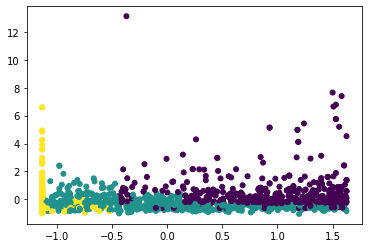

In [18]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)
plt.show()

## SVM

In [19]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale', 1e-2, 1e-3, 1e-4, 1e-5],
          'C'     : [0.001, 0.10, 0.1, 0.5, 1, 10]
         }

grid_search = RandomizedSearchCV(SVC(), params,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

print(grid_search.best_params_)


# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(**grid_search.best_params_).fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), pd.DataFrame(grid_search.cv_results_["mean_test_score"],
                                                                         columns=["Accuracy"])], axis=1)

{'kernel': 'rbf', 'gamma': 'scale', 'C': 1}


,kernel,gamma,C,Accuracy
0,sigmoid,0.01,0.5,0.738569
1,sigmoid,1e-05,0.5,0.403927
2,sigmoid,1e-05,0.1,0.403927
3,sigmoid,0.0001,0.1,0.403927
4,rbf,scale,1.0,0.799439
5,sigmoid,1e-05,0.1,0.403927
6,linear,1e-05,0.5,0.789341
7,rbf,0.001,1.0,0.708555
8,linear,0.01,0.5,0.789341
9,linear,1e-05,0.1,0.785975


In [20]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [21]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8011220196353436
Accuracy test set:  0.8103335513407456

F1 score train set: 0.8000323800901773
F1 score test set:  0.8105137397620258
Train:
              precision    recall  f1-score   support

        High       0.77      0.82      0.79      1189
      Medium       0.72      0.67      0.69      1188
         Low       0.92      0.92      0.92      1188

    accuracy                           0.80      3565
   macro avg       0.80      0.80      0.80      3565
weighted avg       0.80      0.80      0.80      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.77      0.82      0.79       509
      Medium       0.72      0.70      0.71       510
         Low       0.94      0.91      0.93       510

    accuracy                           0.81      1529
   macro avg       0.81      0.81      0.81      1529
weighted avg       0.81      0.81      0.81      1529



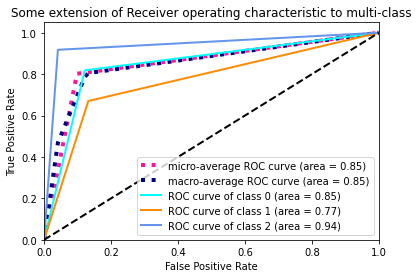

In [22]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

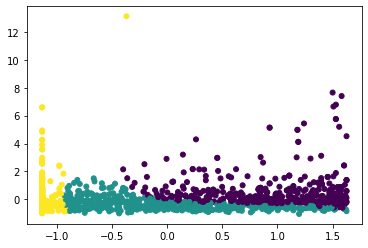

In [23]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_svm, s=25)
plt.show()

## KNN

In [24]:
params = {'n_neighbors': [2, 4, 6, 8, 10, 15, 20, 25, 50],
          'algorithm': ['ball_tree', 'kd_tree']
         }

grid_search = RandomizedSearchCV(KNeighborsClassifier(), params,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

print(grid_search.best_params_)


knn = KNeighborsClassifier(**grid_search.best_params_).fit(train_set, train_label)

{'n_neighbors': 2, 'algorithm': 'ball_tree'}


In [25]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [26]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9175315568022441
Accuracy test set:  0.8358404185742315

F1 score train set: 0.916857732268664
F1 score test set:  0.8320455161336441
Train:
              precision    recall  f1-score   support

        High       0.83      1.00      0.91      1189
      Medium       0.95      0.79      0.86      1188
         Low       1.00      0.96      0.98      1188

    accuracy                           0.92      3565
   macro avg       0.93      0.92      0.92      3565
weighted avg       0.93      0.92      0.92      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.75      0.94      0.84       509
      Medium       0.83      0.64      0.72       510
         Low       0.95      0.92      0.94       510

    accuracy                           0.84      1529
   macro avg       0.84      0.84      0.83      1529
weighted avg       0.84      0.84      0.83      1529



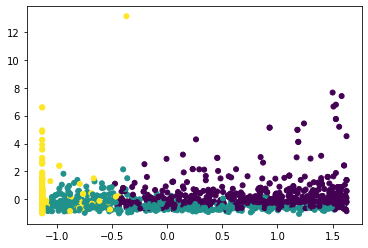

In [27]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_knn, s=25)
plt.show()

## Classification with Random Forest

In [28]:
# Define and fit a random forest.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1, len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2: 0.25}]}

n_iter_search = 50

rf = RandomForestClassifier()
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                 n_iter=n_iter_search,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [29]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 11, 'min_samples_split': 27}


In [30]:
rf = RandomForestClassifier(**grid_search.best_params_).fit(train_set, train_label)

In [31]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [32]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8715287517531557
Accuracy test set:  0.8293001962066711

F1 score train set: 0.87244915500316
F1 score test set:  0.8312861162544245
Train:
              precision    recall  f1-score   support

        High       0.81      0.91      0.86      1189
      Medium       0.82      0.79      0.80      1188
         Low       1.00      0.92      0.96      1188

    accuracy                           0.87      3565
   macro avg       0.88      0.87      0.87      3565
weighted avg       0.88      0.87      0.87      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.78      0.83      0.80       509
      Medium       0.74      0.75      0.75       510
         Low       0.98      0.90      0.94       510

    accuracy                           0.83      1529
   macro avg       0.83      0.83      0.83      1529
weighted avg       0.83      0.83      0.83      1529



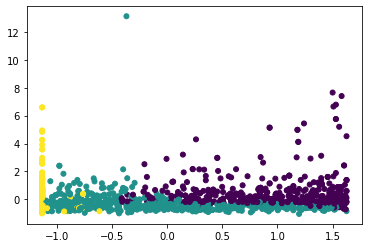

In [33]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_rf, s=25)
plt.show()

## Neural networks

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_clustering[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [36]:
history = model.fit(train_set, train_label_nn,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/100
10/10 [==============================] - 0s 24ms/step - loss: 1.0642 - accuracy: 0.3988 - val_loss: 1.0063 - val_accuracy: 0.6262
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9826 - accuracy: 0.5711 - val_loss: 0.9146 - val_accuracy: 0.6636
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.8991 - accuracy: 0.6281 - val_loss: 0.8264 - val_accuracy: 0.6729
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8283 - accuracy: 0.6513 - val_loss: 0.7507 - val_accuracy: 0.6832
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.7646 - accuracy: 0.6826 - val_loss: 0.6912 - val_accuracy: 0.6953
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.7120 - accuracy: 0.6946 - val_loss: 0.6428 - val_accuracy: 0.7084
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6781 - accuracy: 0.7154 - val_loss: 0.6006 - val_accuracy: 0.7458
Epoch 8/100


Epoch 54/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4626 - accuracy: 0.7872 - val_loss: 0.4437 - val_accuracy: 0.7944
Epoch 55/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4706 - accuracy: 0.7832 - val_loss: 0.4452 - val_accuracy: 0.7907
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4656 - accuracy: 0.7892 - val_loss: 0.4475 - val_accuracy: 0.7879
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4705 - accuracy: 0.7828 - val_loss: 0.4450 - val_accuracy: 0.7897
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.7844 - val_loss: 0.4462 - val_accuracy: 0.7897
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4605 - accuracy: 0.7920 - val_loss: 0.4454 - val_accuracy: 0.7907
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4579 - accuracy: 0.7876 - val_loss: 0.4436 - val_accuracy: 0.7897
Epoch 

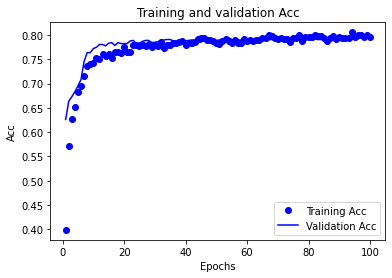

In [37]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [38]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [39]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8042075736325386
Accuracy test set:  0.8234139960758666

F1 score train set: 0.8026808528421725
F1 score test set:  0.8233942983922778
Train:
              precision    recall  f1-score   support

        High       0.75      0.84      0.79      1189
      Medium       0.73      0.65      0.69      1188
         Low       0.93      0.92      0.92      1188

    accuracy                           0.80      3565
   macro avg       0.80      0.80      0.80      3565
weighted avg       0.80      0.80      0.80      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.78      0.85      0.81       509
      Medium       0.75      0.71      0.73       510
         Low       0.95      0.91      0.93       510

    accuracy                           0.82      1529
   macro avg       0.83      0.82      0.82      1529
weighted avg       0.83      0.82      0.82      1529



## Classification with Naive Bayes

In [40]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [41]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7486676016830295
Accuracy test set:  0.761935905820798

F1 score train set: 0.747629467681459
F1 score test set:  0.7610402850101923
Train:
              precision    recall  f1-score   support

        High       0.75      0.63      0.69      1189
      Medium       0.61      0.68      0.65      1188
         Low       0.89      0.93      0.91      1188

    accuracy                           0.75      3565
   macro avg       0.75      0.75      0.75      3565
weighted avg       0.75      0.75      0.75      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.76      0.64      0.70       509
      Medium       0.63      0.70      0.66       510
         Low       0.90      0.94      0.92       510

    accuracy                           0.76      1529
   macro avg       0.77      0.76      0.76      1529
weighted avg       0.77      0.76      0.76      1529



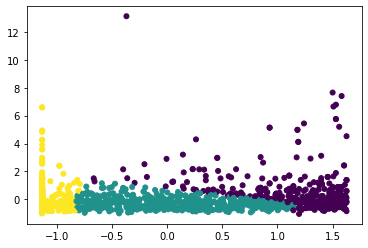

In [42]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_gnb, s=25)